# Hate Speech Detector

In [3]:
import re
import nltk
import numpy as np
import pandas as pd

from nltk import tokenize
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

## Reading data from train and test datasets

In [4]:
training_data = pd.read_csv("../Hate Speech Detector/train.csv")
test_data = pd.read_csv("../Hate Speech Detector/test.csv")

## Preprocessing tweets

In [5]:
lemmatizor = WordNetLemmatizer()
training_data['tweet_text'] = ([' '.join([lemmatizor.lemmatize(re.sub('http\S+','',re.sub('#[^\s]+','',re.sub('@[^\s]+','',(re.sub(r"[^a-zA-Z,!:;/.$&\s#@\'']", '', t.lower())))))) for t in [word for word in text.split(' ') if word not in (stopwords.words('english'))]])for text in training_data['tweet_text']])
test_data['tweet_text'] = ([' '.join([lemmatizor.lemmatize(re.sub('http\S+','',re.sub('#[^\s]+','',re.sub('@[^\s]+','',(re.sub(r"[^a-zA-Z,!:;/.$&\s#@\'']", '', t.lower())))))) for t in [word for word in text.split(' ') if word not in (stopwords.words('english'))]])for text in test_data['tweet_text']])


In [6]:
train_df = pd.DataFrame({'tweet':training_data['tweet_text'], 'result':training_data['hate_speech']})
test_df = pd.DataFrame({'tweet':test_data['tweet_text'], 'result':test_data['hate_speech']})

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegressionCV

## Using Word embeddings

In [8]:
vect = CountVectorizer(stop_words='english', min_df=.002, max_df=.8, ngram_range=(1,3))
tfidfTransformer = TfidfTransformer()
X_train_dtm = vect.fit_transform(train_df.tweet)
X_train_dtm = tfidfTransformer.fit_transform(X_train_dtm)

X_test_dtm = vect.transform(test_df.tweet)
X_test_dtm= tfidfTransformer.transform(X_test_dtm)

## Comparing different classifier models

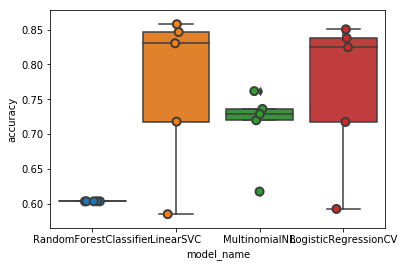

In [17]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegressionCV(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, X_train_dtm, train_df.result, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()


## Training Logistic Regression classifier

In [10]:
lr =LogisticRegressionCV(cv=5, random_state=0,multi_class='multinomial').fit(X_train_dtm, train_df.result)
predicted_class = lr.predict(X_test_dtm)

## Calculating accuracy of classifier

In [11]:
import warnings
warnings.filterwarnings("ignore")
from sklearn import metrics

result_list=[]
for i in range(test_df.result.size):
    result_list.append(test_df.result.loc[i])
    
metrics.accuracy_score(result_list, predicted_class)


0.8604148110446622

## Confusion Matrix

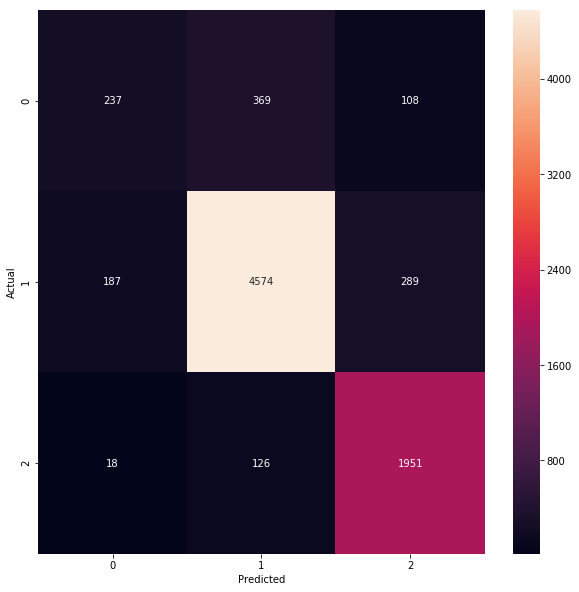

In [13]:
from sklearn.metrics import confusion_matrix

category_id_df = training_data[['hate_speech']].drop_duplicates().sort_values('hate_speech')
conf_mat = confusion_matrix(result_list, predicted_class)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.hate_speech.values, yticklabels=category_id_df.hate_speech.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Writing prediction in output csv folder

In [14]:
predicted_df = pd.DataFrame({'predicted_hate': predicted_class})

test_df['predicted_hate'] = predicted_df
test_df.to_csv("../Hate Speech Detector/output/test.csv")

## Precision Recall F1-Score

In [16]:
print(metrics.classification_report(result_list, predicted_class))


             precision    recall  f1-score   support

          0       0.54      0.33      0.41       714
          1       0.90      0.91      0.90      5050
          2       0.83      0.93      0.88      2095

avg / total       0.85      0.86      0.85      7859

